In [1]:
def multioptions_price(S,r,tau,K):
    M = S.shape[0]
    N = S.shape[1]
    P = K.shape[0]
    u_values = np.zeros((M,P))
    
    for j in range(P):
        for i in range(M):
            
            
            summ = np.sum(np.maximum((S[i,:] - K[j]),0))
            
            u_values[i,j] = np.exp(-r*tau[i])*summ/N
            
        ## alternatively
        #for i in range(M):
        #    S1 = S[i,:] - K[i]
        #    S1[np.where(S1<0)] = 0
        #    V_values[i] = np.exp(-r*tau[i])*np.mean(S1)
    
    return u_values

In [2]:
def Three_half_Euler(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0
    dt = 0.9/(M-1)
    
    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        S[i+1,:] = S[i,:]*np.exp((r-V/2)*dt + np.sqrt(V*dt)*Zs)
        V_delta = V + V*(theta - kappa*V)*dt + epsilon*V**(3/2)*np.sqrt(dt)*Zv
        
        V_delta[np.where(V_delta < 0)] = 0
        V = V_delta
        
    return S

In [3]:
import scipy
import numpy as np
M=100
P=101
N=10000

x = scipy.linspace(0.5,2.,P) # x = S/K
S0 = 2000
tau = np.linspace(0.1,1,M)
v = np.linspace(0.16,0.81,100)
K = S0/x

np.random.seed(0)
u_tilda_ls = []
K_ls = []
tau_ls = []
x_ls = []
v_ls = []
for v0 in v:
    
    S = Three_half_Euler(M,N,0.02, 2,0.055, 2,-0.7,2000,v0)
    #S = GARCH_Milstein(2501,10000,0.02, 2,0.055,0.6,-0.7,2000,0.055)

    u = multioptions_price(S,0.02,tau,K)
    u_tilda = u/K
    
    X,T = np.meshgrid(x,tau)
    
    X = X.flatten()[:,None]
    T = T.flatten()[:,None]
    u_min = np.maximum((X-np.exp(-0.02*T)),0)
    u_tilda = u_tilda.flatten()[:,None]
    
    u_tilda = np.maximum(u_tilda,u_min)
    u_tilda = u_tilda.reshape(M,P)
   
    u_tilda_ls.append(u_tilda)
    
    v_mesh = np.full(u_tilda.shape, v0)
    v_ls.append(v_mesh)

K_mesh,_ = np.meshgrid(K,tau)
x_mesh,tau_mesh = np.meshgrid(x,tau)

for i in range(len(v)):

    # append for stacking
    K_ls.append(K_mesh)
    x_ls.append(x_mesh)
    tau_ls.append(tau_mesh)
    
u_tilda = np.stack(u_tilda_ls,2)
v = np.stack(v_ls,2)
K = np.stack(K_ls,2)
x = np.stack(x_ls,2)
tau = np.stack(tau_ls,2)

data = np.stack((x,tau,v,u_tilda,K),3)

print(data.shape)


(100, 101, 100, 5)


Text(0.5, 0, 'V')

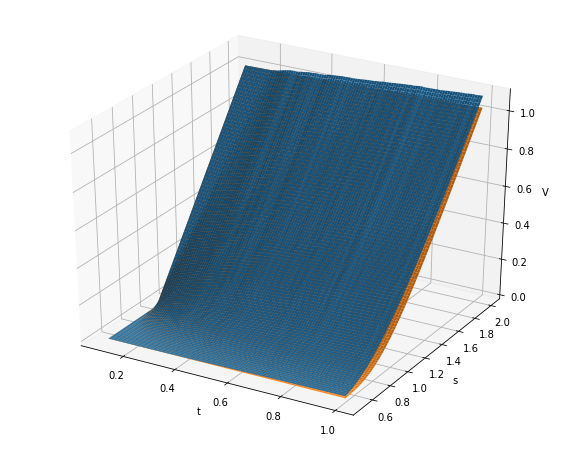

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline
fig = plt.figure(figsize=(10,8))

x = scipy.linspace(0.5,2.,P) # x = S/K
tau = np.linspace(0.1,1,M)
#ax = Axes3D(fig) #<-- Note the difference from your original code...
X,T = np.meshgrid(x,tau)
#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
#for i in range(10):
#ax.plot_surface(T,X,data[:,:,0,2], rstride=1, cstride=1,
#                 edgecolor='none')
ax.plot_surface(T,X,u_tilda[:,:,-1], rstride=1, cstride=1,
                 edgecolor='none')
ax.plot_surface(T,X,u_tilda[:,:,0], rstride=1, cstride=1,
                 edgecolor='none')

ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
#plt.show()

In [5]:
# domain data[tau,x,v,(x_mesh3d,tau_mesh3d,u,K)]

data_dom = data[:,1::,:,:]# retain all except b1
data_dom = data_dom[:,0:-1,:,:]# retain all except b2
data_dom = data_dom[1::,:,:,:]# retain all except ini
data_dom = data_dom[:,:,1::,:]# retain all except b1_v
data_dom = data_dom[:,:,0:-1,:]# retain all except b2_v

# filter initial
data_ini = data[0:1,:,:,:]

# filter boundary
data_bd1 = data[:,0:1,:,:]
data_bd2 = data[:,-1:,:,:]
data_bd1_v = data[:,:,0:1,:]
data_bd2_v = data[:,:,-1:,:]

####
np.random.seed(123)
# flatten, then randomly sample from each domain
# domain:
x_dom = data_dom[:,:,:,0].flatten()
idx_dom = np.random.choice(x_dom.shape[0],5000, replace=False)
x_dom = data_dom[:,:,:,0].flatten()[idx_dom]
t_dom = data_dom[:,:,:,1].flatten()[idx_dom]
v_dom = data_dom[:,:,:,2].flatten()[idx_dom]
u_dom = data_dom[:,:,:,3].flatten()[idx_dom]
K_dom = data_dom[:,:,:,4].flatten()[idx_dom]

# initial:
x_ini = data_ini[:,:,:,0].flatten()
idx_ini = np.random.choice(x_ini.shape[0],5000, replace=False)
x_ini = data_ini[:,:,:,0].flatten()[idx_ini]
t_ini = data_ini[:,:,:,1].flatten()[idx_ini]
v_ini = data_ini[:,:,:,2].flatten()[idx_ini]
u_ini = data_ini[:,:,:,3].flatten()[idx_ini]
K_ini = data_ini[:,:,:,4].flatten()[idx_ini]

# boundary:
x_bd1 = data_bd1[:,:,:,0].flatten()
idx_bd = np.random.choice(x_bd1.shape[0],1250, replace=False)
x_bd1 = data_bd1[:,:,:,0].flatten()[idx_bd]
t_bd1 = data_bd1[:,:,:,1].flatten()[idx_bd]
v_bd1 = data_bd1[:,:,:,2].flatten()[idx_bd]
u_bd1 = data_bd1[:,:,:,3].flatten()[idx_bd]
K_bd1 = data_bd1[:,:,:,4].flatten()[idx_bd]

x_bd2 = data_bd2[:,:,:,0].flatten()[idx_bd]
t_bd2 = data_bd2[:,:,:,1].flatten()[idx_bd]
v_bd2 = data_bd2[:,:,:,2].flatten()[idx_bd]
u_bd2 = data_bd2[:,:,:,3].flatten()[idx_bd]
K_bd2 = data_bd2[:,:,:,4].flatten()[idx_bd]

x_bd1_v = data_bd1_v[:,:,:,0].flatten()
idx_bd_v = np.random.choice(x_bd1_v.shape[0],1250, replace=False)
x_bd1_v = data_bd1_v[:,:,:,0].flatten()[idx_bd_v]
t_bd1_v = data_bd1_v[:,:,:,1].flatten()[idx_bd_v]
v_bd1_v = data_bd1_v[:,:,:,2].flatten()[idx_bd_v]
u_bd1_v = data_bd1_v[:,:,:,3].flatten()[idx_bd_v]
K_bd1_v = data_bd1_v[:,:,:,4].flatten()[idx_bd_v]

x_bd2_v = data_bd2_v[:,:,:,0].flatten()[idx_bd_v]
t_bd2_v = data_bd2_v[:,:,:,1].flatten()[idx_bd_v]
v_bd2_v = data_bd2_v[:,:,:,2].flatten()[idx_bd_v]
u_bd2_v = data_bd2_v[:,:,:,3].flatten()[idx_bd_v]
K_bd2_v = data_bd2_v[:,:,:,4].flatten()[idx_bd_v]



<IPython.core.display.Javascript object>


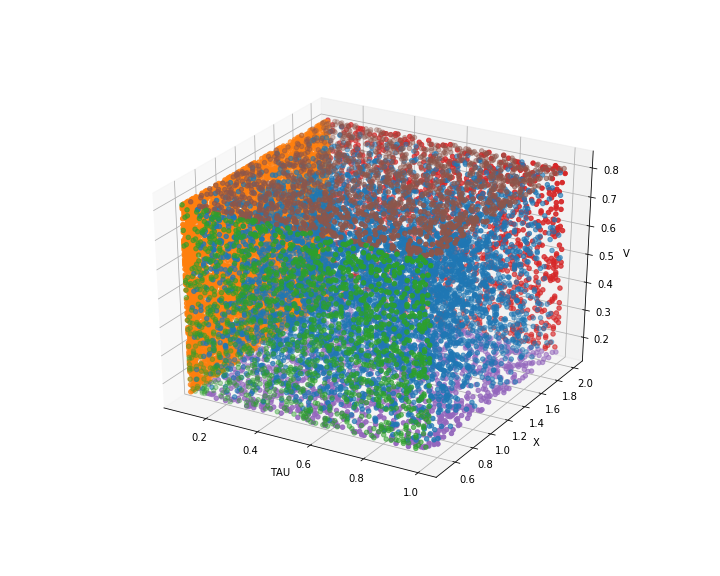

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

x = x_dom
t = t_dom
v = v_dom
ax.scatter(t,x,v)
x = x_ini
t = t_ini
v = v_ini
ax.scatter(t,x,v)
x = x_bd1
t = t_bd1
v = v_bd1
ax.scatter(t,x,v)
x = x_bd2
t = t_bd2
v = v_bd2
ax.scatter(t,x,v)
x = x_bd1_v
t = t_bd1_v
v = v_bd1_v
ax.scatter(t,x,v)
x = x_bd2_v
t = t_bd2_v
v = v_bd2_v
ax.scatter(t,x,v)
ax.set_xlabel('TAU ')
ax.set_ylabel('X ')
ax.set_zlabel('V ')

plt.show()

In [8]:
data = {'t': t_dom, 'x':x_dom, 'v':v_dom, 'usol':u_dom, 'K':K_dom}
import pickle
filename = 'Three_half_Simulation_data_1_v_5000'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

data = {'t': t_ini, 'x':x_ini, 'v':v_ini, 'usol':u_ini, 'K':K_ini}
import pickle
filename = 'Three_half_Simulation_data_1_v_ini_5000'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

data = {'t': t_bd1, 'x':x_bd1, 'v':v_bd1, 'usol':u_bd1, 'K':K_bd1}
import pickle
filename = 'Three_half_Simulation_data_1_v_bd1_5000'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

data = {'t': t_bd2, 'x':x_bd2, 'v':v_bd2, 'usol':u_bd2, 'K':K_bd2}
import pickle
filename = 'Three_half_Simulation_data_1_v_bd2_5000'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

data = {'t': t_bd1_v, 'x':x_bd1_v, 'v':v_bd1_v, 'usol':u_bd1_v, 'K':K_bd1_v}
import pickle
filename = 'Three_half_Simulation_data_1_v_bd1_v_5000'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

data = {'t': t_bd2_v, 'x':x_bd2_v, 'v':v_bd2_v, 'usol':u_bd2_v, 'K':K_bd2_v}
import pickle
filename = 'Three_half_Simulation_data_1_v_bd2_v_5000'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [9]:
tot = np.concatenate((x_dom[:,None],t_dom[:,None], v_dom[:,None], u_dom[:,None], K_dom[:,None]),1)

# filter a particular v
tot = tot[tot[:,2] == 0.5605050505050505]

tot_t = tot[tot[:,1].argsort()][:,1:2]
tot_x = tot[tot[:,0].argsort()][:,0:1]

tot_t_uni = np.unique(tot_t)
tot_x_uni = np.unique(tot_x)

X, T = np.meshgrid(tot_x_uni, tot_t_uni)

from scipy.interpolate import griddata
U_actual = griddata(tot[:,0:2],tot[:,3:4], (X, T), method='cubic')
U_pred = griddata(tot[:,0:2],tot[:,3:4], (X, T), method='cubic')

In [10]:
import numpy as np
import matplotlib as mpl
#mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    #"figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    print(figsize(width, nplots))
    return fig, ax


<IPython.core.display.Javascript object>


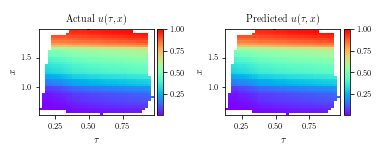

[5.3964300539643, 2.00110631475682]


Text(0.5, 1.0, 'Predicted $u(\\tau,x)$')

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
fig, ax = newfig(1.0, 0.6)
ax.axis('off')

####### Actual: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs0[:, 0])

h = ax.imshow(np.squeeze(U_actual.T), interpolation='nearest', cmap='rainbow', 
                  extent=[tot_t_uni.min(), tot_t_uni.max(), tot_x_uni.min(), tot_x_uni.max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel(r'$\tau$')
ax.set_ylabel('$x$')
#ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
ax.set_title(r'Actual $u(\tau,x)$', fontsize = 10)


####### Predicted: u(t,x) ##################  
ax = plt.subplot(gs0[:, 1])
h = ax.imshow(np.squeeze(U_pred.T), interpolation='nearest', cmap='rainbow', 
                  extent=[tot_t_uni.min(), tot_t_uni.max(), tot_x_uni.min(), tot_x_uni.max()], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel(r'$\tau$')
ax.set_ylabel('$x$')
#ax.legend(loc='upper center', bbox_to_anchor=(1.0, -0.125), ncol=5, frameon=False)
ax.set_title(r'Predicted $u(\tau,x)$', fontsize = 10)

In [16]:
tot = np.concatenate((x_dom[:,None],t_dom[:,None], v_dom[:,None], u_dom[:,None], K_dom[:,None]),1)
np.unique(tot[tot[:,2].argsort()][:,2])[60]

0.5605050505050505